In [1]:
'''
Author: Ivan Gvozdanovic
Date: 10/02/2024
Description:
    GAE A2C algorithm for sampling Fibers.
''';

In [2]:
'''
Good reading material: 

    https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/03-actor-critic.ipynb
    https://github.com/Lucasc-99/Actor-Critic/blob/master/src/a2c.py
    https://github.com/pytorch/examples/blob/main/reinforcement_learning/actor_critic.py
    https://github.com/Francesco-Sovrano/Framework-for-Actor-Critic-deep-reinforcement-learning-algorithms
    https://github.com/tensorflow/docs/blob/master/site/en/tutorials/reinforcement_learning/actor_critic.ipynb
    
    https://www.reddit.com/r/reinforcementlearning/comments/aux7a5/question_about_nstep_learning_with_dqn/
    https://datascience.stackexchange.com/questions/46245/off-policy-n-step-learning-with-dqn/46260#46260
    https://people.cs.umass.edu/~barto/courses/cs687/Chapter%207.pdf
    https://arxiv.org/pdf/1606.02647
    https://arxiv.org/abs/1901.07510
''';

In [6]:
import numpy as np
import sys
import os
import networkx as nx
import itertools
from collections import deque
import time as Time
import torch
from collections import namedtuple
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

from DeepFiberSamplingGaussianENV import PolytopeENV as Env 


In [7]:
from reward_functions import reward_cost, calculate_reward1, calculate_reward2, calculate_reward3

$\LARGE \textbf{Pick Which Problem To Sample}$

In [8]:
#Pick the file to the problem:
problem_name = '4x4LargeValues_'
# problem_name = '4x4_01_Values_'
# problem_name = 'Dobra_'
# problem_name = 'mediumComponent'

$\LARGE \textbf{Extract The Basis Moves}$

In [9]:
from helper_functions import create_fiber_sampling_erdos_renyi_graph, \
                             extract_distance_matrix, \
                             create_real_data_graph, \
                             create_real_data_initial_sol,\
                             moving_average, \
                             create_state_graph, \
                             create_design_mat

from stats_problems import return_stats_problem_1, return_stats_problem_2, return_stats_problem_3

initial_states = {} # dictionary holding the initial states.
patches = 1
node_num = 4
p = 0.8
graph_num = 1
available_actions = None
design_mat = None
margin = None


if problem_name == 'mediumComponent':
    path_initial = os.getcwd() + os.sep + 'Real Data' + os.sep + 'MediumComponent' + os.sep + 'nextComponentMtx.txt'
    initial_states, available_actions, node_num = create_real_data_graph(path_initial)
if problem_name == '4x4LargeValues_':
    node_num, initial_states, available_actions, design_mat, margin = return_stats_problem_1()
if problem_name == '4x4_01_Values_':
    node_num, initial_states, available_actions, design_mat, margin = return_stats_problem_2()
if problem_name == 'Dobra_':
    node_num, initial_states, available_actions, design_mat, margin = return_stats_problem_3()

print(len(available_actions))
print(len(available_actions[0]), available_actions)
print(initial_states[0].shape, initial_states[0])

print(len(margin), margin)

9
16 [[1, -1, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, -1, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, -1, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, -1, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, -1, 0, 0, -1, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, -1, 0, 0, -1, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, -1, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, -1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, -1, 1]]
(16,) [10  0  0  2  0  3  0 40 10  0  2  0  0  3 40  0]
8 [12 43 12 43 20  6 42 42]


$\LARGE \textbf{Setup Hyperparameters}$

In [10]:
save_data = False  # save Q table data and cost vector data.
save_plots = True  # save the plots
save_data_rate = 20

# Example usage for running episodes
num_episodes = 800
max_path_length = 100


# n_step = max_path_length
n_step = num_episodes * max_path_length // 2000
print(f'Train every: {n_step} steps and total number of training periods: {num_episodes * max_path_length // n_step}')
gamma = 0.9
lam = 0.5
discount_factor = gamma
entropy_param = 0.01



sheduler_lr_update = 1 # every 10 trainig periods we modify the step size
actor_lr = 0.0007
critic_lr = 0.0007
step_size = num_episodes//sheduler_lr_update
lr_actor_gamma = (0.00001/actor_lr)**(1/sheduler_lr_update)
lr_critic_gamma = (0.00001/critic_lr)**(1/sheduler_lr_update)
print(step_size)
print(lr_actor_gamma)
print(lr_critic_gamma)



lb = -5
ub = 5


mask_size = 9
mask_rate = 50
mask_action_size = [(len(available_actions)//mask_size) for i in range(mask_size)]
mask_action_size[-1] += len(available_actions)%mask_size # add the remained if not divisible.
mask_range = mask_action_size[0]
print(mask_action_size)
action_space_values = [ [i+lb for i in range(ub-lb)] for j in range(len(available_actions)) ]
action_space_size = [ub-lb for i in range(len(available_actions))]
print(len(action_space_size))


Train every: 40 steps and total number of training periods: 2000
800
0.014285714285714287
0.014285714285714287
[1, 1, 1, 1, 1, 1, 1, 1, 1]
9


$\LARGE \textbf{Setup RL Model}$

In [21]:
from GaussianA2C import TransformerPolicy, \
                        select_action_transformer, \
                        run_n_step_with_gae, \
                        run_n_step_with_gae_cont, \
                        visualize_gaussian_distribution, \
                        freeze_parameters, \
                        generate_mask

model = TransformerPolicy(len(initial_states[0]), len(action_space_size), mask_action_size, mask_rate, lb, ub)
print(model)

optimizer = torch.optim.Adam([
    {'params': model.transformer_encoder.parameters()},   # Shared feature extractor
    {'params': model.mean_head.parameters(), 'lr': actor_lr},  # Actor-specific parameters
    {'params': model.log_std_head.parameters(), 'lr': actor_lr},  # Actor-specific parameters
#     {'params': model.cov_head.parameters(), 'lr': actor_lr},  # Actor-specific parameters
    {'params': model.mask_heads.parameters(), 'lr': actor_lr}, # Mask-specific parameters
    {'params': model.value_head.parameters(), 'lr': critic_lr} # Critic-specific parameters
])

scheduler_actor = StepLR(optimizer, step_size=step_size, gamma=lr_actor_gamma)
scheduler_critic = StepLR(optimizer, step_size=step_size, gamma=lr_critic_gamma)
eps = np.finfo(np.float32).eps.item()
SavedAction = namedtuple('SavedAction', ['log_probs', 'value', 'probs', 'mask_log_probs'])

TransformerPolicy(
  (embedding): Linear(in_features=16, out_features=64, bias=True)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (mean_head): Linear(in_features=64, out_features=9, bias=True)
  (log_std_head): Linear(in_features=64, out_fe

$\LARGE \textbf{Initialize Environment}$

In [22]:
# Convert dictionary values to a list of arrays
visited_states = [np.array(initial_states[0])]
visited_states = np.stack(visited_states)

#Initialize the environment.
env = Env(initial_states, # initial_state
         num_episodes, # total_episodes
         max_path_length,
         50, # show_path_num
         visited_states,  # visited_states
         available_actions, # basis_moves
         node_num, # node_num
         0, # P
         lb, #lb
         True)



$\LARGE \textbf{Pick Learning Technique:}$

$\Large \textbf{Continues RL}$

In [ ]:
cumm_running_reward = 0
episode_reward_list = []
cumm_running_reward_list = []
loss_list = []
actor_lr_list = []
critic_lr_list = []
robins_monro_condition = []


start_time = Time.time()
iteration = 0
training_period = 0

# reset environment and episode reward
state = env.reset()
ep_reward = 0
done = False

# for each episode, only run 9999 steps so that we don't
# infinite loop while learning
while not done:


    # select action from policy
#         action = select_action(model, state, SavedAction, action_space_values, False)
    action = select_action_transformer(model, state, SavedAction, action_space_values, mask_range, iteration, False)


    # take the action
    state, reward, done, _ = env.step_cont(action)

    model.rewards.append(reward)
    cumm_running_reward += reward
    cumm_running_reward_list.append(reward)
    # perform backprop
    actor_lr, critic_lr, training_period = run_n_step_with_gae_cont(model, n_step, gamma, lam, optimizer, 
                                             scheduler_actor, scheduler_critic,  0.998, 
                                              0.996, entropy_param, training_period, iteration, done)

    if actor_lr != None and critic_lr != None:
        actor_lr_list.append(actor_lr)
        critic_lr_list.append(critic_lr)
        robins_monro_condition.append(critic_lr/actor_lr)
    if done:
        break

    iteration += 1

    if (iteration) % save_data_rate == 0:
        torch.save(model.state_dict(), 'Models/'+problem_name+'policy_model_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.pth')
        end_time = Time.time()
        print(f'It took {(end_time-start_time)/60} minutes to run {iteration} steps.')

# episode_reward_list.append(ep_reward)
    
torch.save(model.state_dict(), 'Models'+problem_name+'policy_model_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.pth')


end_time = Time.time()
print(f'It took {(end_time-start_time)/60} minutes to run {num_episodes} episodes.')

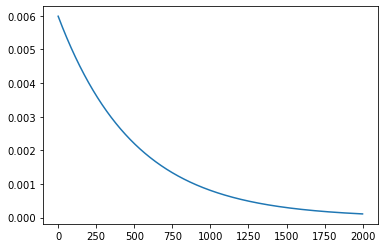

In [14]:
lr = []
start = 0.006
for i in range(2000):
    decay_factor1 = 0.998 ** (1 + 0.000000001 * i)
    start *= decay_factor1
    lr.append(start )
    
plt.plot(lr)


[0, 100, 200, 300, 400, 500, 600, 700, 800]


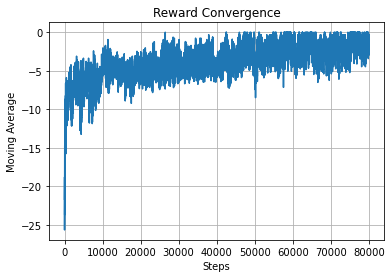

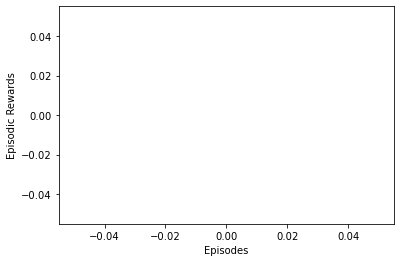

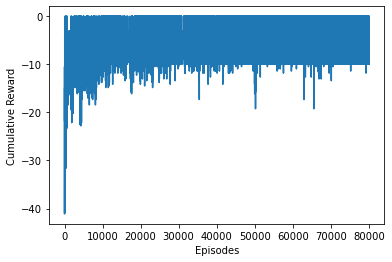

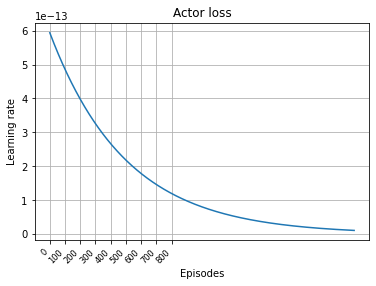

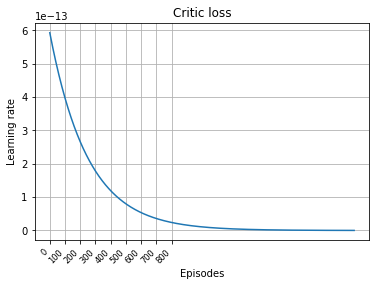

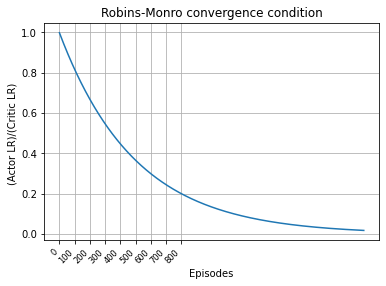

In [24]:
cum_reward_x_axis = [i for i in range(len(cumm_running_reward_list))]
ep_reward_x_axis = [i for i in range(len(episode_reward_list))]
loss_x_axis = [i for i in range(len(loss_list))]
actor_lr_x_axis = [i for i in range(len(actor_lr_list))]
critic_lr_x_axis = [i for i in range(len(critic_lr_list))]


tick_num = num_episodes//100
custom_x_values = [i*100 for i in range(0,tick_num+1)]
custom_x_values = sorted(custom_x_values)
print(custom_x_values)
custom_x_labels = [str(i) for i in custom_x_values]

smoothed_rewards = moving_average(cumm_running_reward_list, 10)
smoothed_rewards_x_axis = [i for i in range(len(smoothed_rewards))]

plt.plot(smoothed_rewards_x_axis, smoothed_rewards)
plt.xlabel("Steps")
plt.ylabel("Moving Average")
plt.title("Reward Convergence")
# plt.xticks(ticks=custom_x_values, labels=custom_x_labels, rotation=45, ha='right', size='small')
plt.grid(visible=True)
if save_plots:
    plt.savefig("Figures/RewardConvergence_"+problem_name+"_Node#_"+str(node_num)+"_EP_"+ str(num_episodes)+".png")
plt.show()

plt.plot(ep_reward_x_axis, episode_reward_list)
plt.xlabel("Episodes")
plt.ylabel("Episodic Rewards")
plt.show()
plt.plot(cum_reward_x_axis, cumm_running_reward_list)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.show()
plt.plot(actor_lr_x_axis, actor_lr_list)
plt.xticks(ticks=custom_x_values, labels=custom_x_labels, rotation=45, ha='right', size='small')
plt.grid(visible=True)
plt.title("Actor loss")
plt.xlabel("Episodes")
plt.ylabel("Learning rate")
if save_plots:
    plt.savefig("Figures/ActorLoss_"+problem_name+"_Node#_"+str(node_num)+"_EP_"+ str(num_episodes)+".png")
plt.show()
plt.plot(critic_lr_x_axis, critic_lr_list)
plt.xticks(ticks=custom_x_values, labels=custom_x_labels, rotation=45, ha='right', size='small')
plt.grid(visible=True)
plt.title("Critic loss")
plt.ylabel("Learning rate")
plt.xlabel("Episodes")
if save_plots:
    plt.savefig("Figures/CriticLoss_"+problem_name+"_Node#_"+str(node_num)+"_EP_"+ str(num_episodes)+".png")
plt.show()

plt.plot(critic_lr_x_axis,robins_monro_condition)
plt.xticks(ticks=custom_x_values, labels=custom_x_labels, rotation=45, ha='right', size='small')
plt.grid(visible=True)
plt.title("Robins-Monro convergence condition")
plt.ylabel("(Actor LR)/(Critic LR) ")
plt.xlabel("Episodes")
plt.show()

In [25]:
def compute_autocorrelation_norm(series, max_lag):
    """
    Compute the autocorrelation of the norm of vector-valued states.
    """
    series = np.array(series)  # Ensure it's a NumPy array
    norms = np.linalg.norm(series, axis=1)  # Compute norms of each vector
    n = len(norms)
    mean = np.mean(norms)
    autocorr_values = []
    
    for lag in range(1, max_lag + 1):
        cov = np.sum((norms[:n-lag] - mean) * (norms[lag:] - mean)) / n
        var = np.sum((norms - mean)**2) / n
        autocorr_values.append(cov / var)
    
    return autocorr_values

def plot_autocorrelation_norm(series, max_lag):
    """
    Plot the autocorrelation of the norm of vector-valued states.
    """
    autocorr_values = compute_autocorrelation_norm(series, max_lag)
    lags = range(1, max_lag + 1)
    
    plt.figure(figsize=(8, 6))
    plt.stem(lags, autocorr_values, use_line_collection=True)
    plt.title("Autocorrelation of MCMC Chain (Norm of States)")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.grid()
    plt.show()


    
def compute_autocorrelation_vectorized(series, max_lag):
    """
    Compute the autocorrelation for each dimension of a vector-valued series.
    """
    series = np.array(series)  # Ensure it's a NumPy array
    n, d = series.shape  # n: number of samples, d: dimensions of state
    autocorr_values = np.zeros((max_lag, d))
    
    mean = np.mean(series, axis=0)  # Mean for each dimension
    
    for lag in range(1, max_lag + 1):
        for dim in range(d):  # Compute for each dimension
            cov = np.sum((series[:n-lag, dim] - mean[dim]) * 
                         (series[lag:, dim] - mean[dim])) / n
            var = np.sum((series[:, dim] - mean[dim])**2) / n
            autocorr_values[lag-1, dim] = cov / var
    
    return autocorr_values

def plot_autocorrelation_vectorized(series, max_lag):
    """
    Plot the autocorrelation for each dimension of a vector-valued series.
    """
    autocorr_values = compute_autocorrelation_vectorized(series, max_lag)
    lags = range(1, max_lag + 1)
    dims = autocorr_values.shape[1]
    
    plt.figure(figsize=(10, 6))
    for dim in range(dims):
        plt.stem(lags, autocorr_values[:, dim], label=f"Dimension {dim+1}", use_line_collection=True)
    
    plt.title("Autocorrelation of MCMC Chain (Each Dimension)")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.legend()
    plt.grid()
    plt.show()

$\LARGE \textbf{Compute Autocorrelation Of the Sampler}$

In [26]:
print("Problem name: ", problem_name)

model = TransformerPolicy(len(initial_states[0]), len(action_space_size), mask_action_size, mask_rate, lb, ub)
model.load_state_dict(torch.load('Models/'+problem_name+'policy_model_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.pth'))
model.eval()


step = 0
path = []
path_length = 5000

state = env.reset()
path.append(state)
done = False


#Initialize the environment.
env = Env(initial_states, # initial_state
     1, # total_episodes
     max_path_length,
     50, # show_path_num
     visited_states,  # visited_states
     available_actions, # basis_moves
     node_num, # node_num
     0, # P
     lb, #lb
     False)


for i in range(path_length):
    action = select_action_transformer(model, state, SavedAction, action_space_values, mask_range, i, True)
    
    action_rounded = np.array(np.round(action), dtype=int)
    all_actions = [np.multiply(action_rounded[i], available_actions[i]) for i in range(len(action_rounded))]
    all_actions = np.stack(all_actions)
    action = np.sum(all_actions, 0)
    
    next_state = np.add(state, action)
    
    if all(coord >= 0 for coord in next_state):
        path.append(next_state)
    state = next_state

Problem name:  4x4LargeValues_


<ipython-input-26-456d3a05c829>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Models/'+problem_name+'policy_model_Node#_' + str(node_num

Length of the chain is 1554


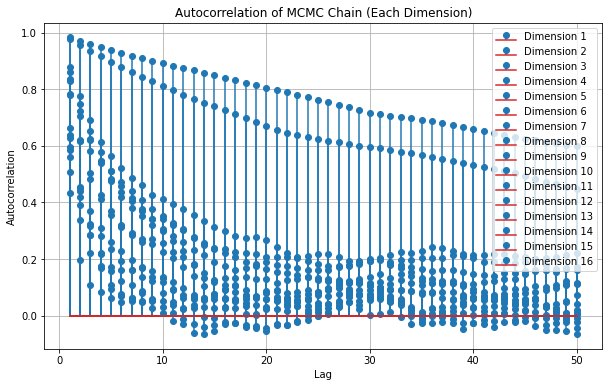

In [29]:
print(f'Length of the chain is {len(path)}')
# plot_autocorrelation_norm(np.array(path), max_lag=50)
plot_autocorrelation_vectorized(np.array(path), max_lag=50)

$\LARGE \textbf{Run Trained Policy and Get Sample}$

In [ ]:
from stats_functions import find_exchangable_sample, compute_chi_square


print("Problem name: ", problem_name)

model = TransformerPolicy(len(initial_states[0]), len(action_space_size), mask_action_size, mask_rate, lb, ub)
model.load_state_dict(torch.load('Models/'+problem_name+'policy_model_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.pth'))
model.eval()

sim_num = 100 # number of times we run the algorithm.
chain_num = 100 # 100 points per simulation.
max_path_length = 100
p_list = []


start_time = Time.time()


for sim in range(sim_num):
    
    print("#############################################################################################")
    print("#############################################################################################")
    print("#############################################################################################")
    print("#############################################################################################")
    print("#############################################################################################")
    print("#############################################################################################")
    print("#######################  SIM NUMBER: ", sim, " #####################")
    # Convert dictionary values to a list of arrays
    visited_states = [np.array(initial_states[0])]
    visited_states = np.stack(visited_states)

    computed_sample = find_exchangable_sample(model,
                                                SavedAction,
                                                initial_states,
                                                num_episodes,
                                                max_path_length,
                                                visited_states,
                                                available_actions,
                                                action_space_values,
                                                mask_range,
                                                node_num,
                                                lb,
                                                ub,
                                                chain_num)

    nodes = [i for i in range(node_num)]

    p = compute_chi_square(problem_name, initial_states[0], margin, computed_sample, nodes, num_episodes)
    p_list.append(p)
    


end_time = Time.time()
print(f'It took {(end_time-start_time)/60} minutes to run {num_episodes} episodes.')

In [10]:
print(p_list)
print("Average p-value: ", sum(p_list)/len(p_list))
np.save('Models/'+problem_name+'p_values_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.npy', p_list)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Average p-value:  0.0


In [11]:
def calculate_frequencies(data_list):
    from collections import Counter
    # Use Counter to calculate frequencies
    frequency_dict = dict(Counter(data_list))
    return frequency_dict

#Pick the file to the problem:
problem_name = '4x4LargeValues_'
# problem_name = '4x4_01_Values_'
# problem_name = 'Dobra_'
# problem_name = 'mediumComponent'

p_list = np.load('Models/'+problem_name+'p_values_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.npy')
freq_dict = calculate_frequencies(p_list)
freq_dict = dict(sorted(freq_dict.items()))
print(freq_dict)

{0.0: 100}


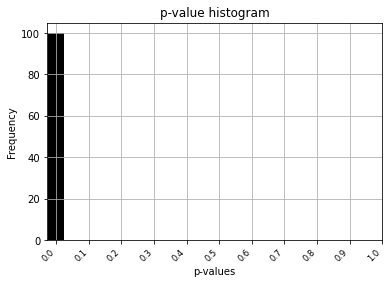

In [12]:
custom_x_values = [np.round(i*0.1,2) for i in range(len(list(freq_dict.keys())) + 10)]
custom_x_values = sorted(custom_x_values)
custom_x_labels = [str(i) for i in custom_x_values]
widts = [0.05 for i in range(len(freq_dict.keys()))]
plt.bar(freq_dict.keys(), freq_dict.values(), width = widts, color='black')
plt.xticks(ticks=custom_x_values, labels=custom_x_labels, rotation=45, ha='right', size='small')
plt.xlabel('p-values')
plt.ylabel('Frequency')
plt.title('p-value histogram')
plt.grid(visible=True)
plt.savefig("Figures/p_value_histogram_"+problem_name+"_Node#_"+str(node_num)+"_EP_"+ str(num_episodes)+".png")
plt.show()